In [1]:
import pandas as pd
import numpy as np
import os
import random
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [2]:
def set_seed_xg(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
   
    print(f"--- All seed has been fixed to {seed} ---")

In [3]:
def train_xgboost_model():
    
    set_seed_xg(42)

    
    data_path = '../data_engineered/modern_train_ready_v2.csv'
    if not os.path.exists(data_path):
        print("No preprocessed data file found. Please run the preprocessing code first.")
        return

    df = pd.read_csv(data_path)
    
    
    feature_cols = [
        'grid', 'qual_pos', 'q_rel_gap', 'age_at_race', 
        'driver_form', 'team_form', 'driver_experience', 'circuit_avg_pos'
    ]
    target_col = 'sprint_target'

    X = df[feature_cols]
    y = df[target_col]

    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    
    model = xgb.XGBRegressor(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        n_jobs=-1,
        random_state=42, 
        early_stopping_rounds=50 
    )

    print("--- Step 2: XGBoost Training Start ---")
    
    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False 
    )

    
    preds = model.predict(X_val)
    mse = mean_squared_error(y_val, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_val, preds)

    print(f"\n[Model Evaluation Results]")
    print(f"- MSE  : {mse:.4f}")
    print(f"- RMSE : {rmse:.4f} (Average error of about {rmse:.1f} positions)")
    print(f"- MAE  : {mae:.4f}")

    
    importances = pd.Series(model.feature_importances_, index=feature_cols).sort_values(ascending=True)
    print("\n[Feature Importance (Descending)]")
    print(importances.sort_values(ascending=False))

    
    model_dir = '../models'
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    joblib.dump(model, os.path.join(model_dir, 'xgb_f1_model.pkl'))
    
    
    plt.figure(figsize=(10, 6))
    importances.plot(kind='barh', title='Feature Importance in F1 Sprint (Seed: 42)')
    plt.xlabel('Importance Score')
    plt.ylabel('Features')
    
    image_path = os.path.join(model_dir, 'feature_importance.png')
    plt.savefig(image_path, bbox_inches='tight')
    plt.show()
    print(f"\nFinal results saved to: {model_dir}/")
    plt.close()

    return model

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
class F1SequenceDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)
    def __len__(self): return len(self.x)
    def __getitem__(self, idx): return self.x[idx], self.y[idx]

In [6]:
def prepare_f1_data(df, feature_cols, target_col, seq_len=3):
    scaler = StandardScaler()
    df_scaled = df.copy()
    df_scaled[feature_cols] = scaler.fit_transform(df[feature_cols])
    
    xs, ys = [], []
    for _, group in df_scaled.groupby('driverId'):
        group = group.sort_values(['year', 'round'])
        f_vals = group[feature_cols].values
        t_vals = group[target_col].values
        
        if len(group) <= seq_len: continue
        for i in range(len(group) - seq_len):
            xs.append(f_vals[i:(i + seq_len)])
            ys.append(t_vals[i + seq_len])
            
    return np.array(xs), np.array(ys), scaler


In [7]:
class F1RefinedWeightedPredictor(nn.Module):
    def __init__(self, input_dim, importance_map, feature_cols, hidden_dim=64):
        super(F1RefinedWeightedPredictor, self).__init__()
        
        
        importance_weights = torch.tensor(
            [importance_map.get(c, 1.0) for c in feature_cols], 
            dtype=torch.float32
        )
        
        self.feature_priority = nn.Parameter(importance_weights)
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=2, batch_first=True, dropout=0.1)
        
        
        self.attention = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.Tanh(),
            nn.Linear(hidden_dim // 2, 1)
        )
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        
        
        weighted_x = x * self.feature_priority
        
        
        lstm_out, _ = self.lstm(weighted_x)
        
        
        attn_weights = torch.softmax(self.attention(lstm_out), dim=1)
        context = torch.sum(attn_weights * lstm_out, dim=1)
        
        
        return self.fc(context)


In [8]:
def run_analysis_v3():
    
    data_path = '../data_engineered/modern_train_ready_v2.csv'
    if not os.path.exists(data_path):
        print("No data file found.")
        return
        
    df = pd.read_csv(data_path)
    
    FEATURE_COLS = ['grid', 'qual_pos', 'q_rel_gap', 'age_at_race', 'driver_form', 'team_form', 'driver_experience', 'circuit_avg_pos']
    IMPORTANCE_MAP = {
        'team_form': 0.450637, 'driver_form': 0.189334, 'qual_pos': 0.094745,
        'circuit_avg_pos': 0.061325, 'driver_experience': 0.060547,
        'grid': 0.051296, 'age_at_race': 0.046638, 'q_rel_gap': 0.045478
    }

    
    X, y, scaler = prepare_f1_data(df, FEATURE_COLS, 'sprint_target', seq_len=3)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_loader = DataLoader(F1SequenceDataset(X_train, y_train), batch_size=32, shuffle=True)
    test_loader = DataLoader(F1SequenceDataset(X_test, y_test), batch_size=1)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = F1RefinedWeightedPredictor(len(FEATURE_COLS), IMPORTANCE_MAP, FEATURE_COLS).to(device)
    
    
    criterion = nn.SmoothL1Loss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    print(f"--- V3 Refined Model Training Start (Device: {device}) ---")
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for bx, by in train_loader:
            bx, by = bx.to(device), by.to(device)
            optimizer.zero_grad()
            outputs = model(bx)
            loss = criterion(outputs, by)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        
        model.eval()
        v_mae = 0
        with torch.no_grad():
            for vx, vy in test_loader:
                v_p = model(vx.to(device))
                v_mae += nn.L1Loss()(v_p, vy.to(device)).item()
        
        current_mae = v_mae / len(test_loader)
        scheduler.step(current_mae)
        
        if (epoch + 1) % 20 == 0:
            print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {train_loss/len(train_loader):.4f} | Val MAE: {current_mae:.4f}")

    
    model.eval()
    all_preds, all_actuals = [], []
    with torch.no_grad():
        for tx, ty in test_loader:
            all_preds.append(model(tx.to(device)).item())
            all_actuals.append(ty.item())

    final_mae = mean_absolute_error(all_actuals, all_preds)
    final_mse = mean_squared_error(all_actuals, all_preds)

    print("\n" + "="*50)
    print("--- V3 Final Analysis Report ---")
    print(f"1. MAE  : {final_mae:.4f}")
    print(f"2. MSE  : {final_mse:.4f}")
    print(f"3. RMSE : {np.sqrt(final_mse):.4f}")
    print(f"\nSuccess Factors: StandardScaler + XGBoost Priority Weighting")
    print("="*50)


--- All seed has been fixed to 42 ---
--- Step 2: XGBoost Training Start ---

[Model Evaluation Results]
- MSE  : 17.1001
- RMSE : 4.1352 (Average error of about 4.1 positions)
- MAE  : 3.2384

[Feature Importance (Descending)]
team_form            0.450637
driver_form          0.189334
qual_pos             0.094745
circuit_avg_pos      0.061325
driver_experience    0.060547
grid                 0.051296
age_at_race          0.046638
q_rel_gap            0.045478
dtype: float32


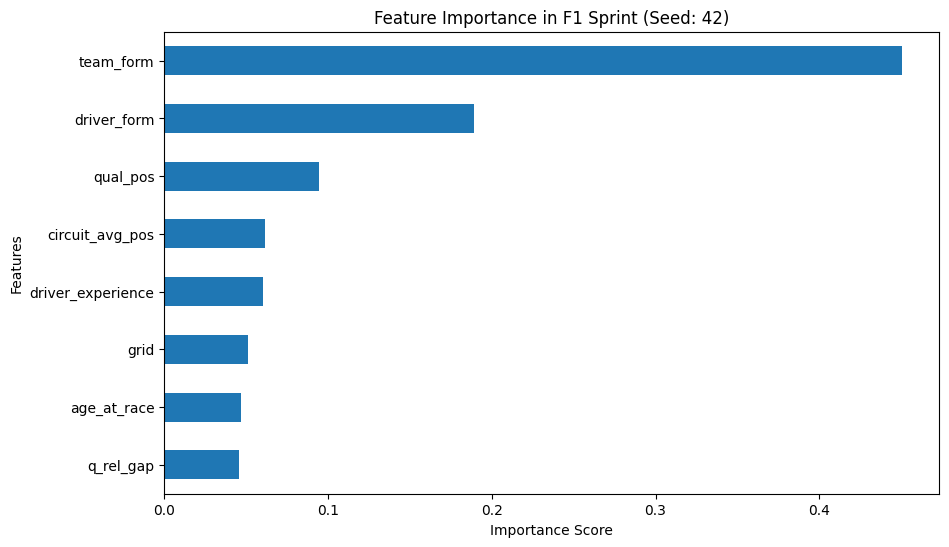


Final results saved to: ../models/


In [9]:
if __name__ == "__main__":
    xgb_model = train_xgboost_model()

In [10]:
if __name__ == "__main__":
    run_analysis_v3()

--- V3 Refined Model Training Start (Device: cuda) ---
Epoch [20/100] Train Loss: 3.0233 | Val MAE: 2.9754
Epoch [40/100] Train Loss: 2.9852 | Val MAE: 2.7904
Epoch [60/100] Train Loss: 2.8541 | Val MAE: 2.7608
Epoch [80/100] Train Loss: 2.9011 | Val MAE: 2.7524
Epoch [100/100] Train Loss: 2.8847 | Val MAE: 2.7526

--- V3 Final Analysis Report ---
1. MAE  : 2.7526
2. MSE  : 11.8846
3. RMSE : 3.4474

Success Factors: StandardScaler + XGBoost Priority Weighting
